# Ajustar (finetune) un modelo de BERT usando sus propios textos de ejemplo, y usar el modelo modificado para clasificar.

Esta notebook carga un modelo de BERT ya entrenado (ver el nombre del modelo en la variable BERT_MODEL) y hace finetuning del modelo para entrenarlo de manera de clasificar mejor textos en diferentes categorías.

Luego utiliza ese modelo para clasificar nuevos textos.

Código basado en [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning).

In [ ]:
!pip install transformers==4.31.0

import torch

# Hay una GPU disponible?
is_gpu = torch.cuda.is_available()
if is_gpu:
    # Decile a PyTorch que use la GPU.
    device = torch.device("cuda")
    print(f'\nHay {torch.cuda.device_count()} GPU(s) disponible(s).')
    print(f'Vamos a usar la GPU: {torch.cuda.get_device_name(0)}.\n')
# si no hay GPU...
else:
    print('\nNo hay GPU disponible, vamos a usar la CPU.\n')
    device = torch.device("cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.

Hay 1 GPU(s) disponible(s).
Vamos a usar la GPU: Tesla T4.



# Parte 1: Ejecutar el fine tuning

In [ ]:
# Cargar el tokenizador correspondiente al modelo de BERT que vamos a usar.
# TIENE que ser exactamente el mismo.
from transformers import BertTokenizer

# Este es el nombre en Huggingface del modelo de BERT ya entrenado que vamos a usar.
# Ver https://huggingface.co/models?language=es&sort=downloads para mas modelos en castellano.
BERT_MODEL = 'Recognai/bert-base-spanish-wwm-cased-xnli'
# Otros posibles modelos p.ej.:
#   'dccuchile/bert-base-spanish-wwm-cased'
#   'mrm8488/distill-bert-base-spanish-wwm-cased-finetuned-spa-squad2-es'
print('Cargando tokenizador de BERT...')
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
print('\nTokenizador de BERT listo.')

Cargando tokenizador de BERT...

Tokenizador de BERT listo.


### Cargar los ejemplos que vamos a usar para hacer fine tuning

In [ ]:
import pandas as pd
import numpy as np
# Aqui ud. debe cargar su dataset para hacer fine tuning.
# my_dataset = ....
# Aqui hay un dataset de ejemplo. IMPORTANTE! Este es solo un dataset de ejemplo, use el suyo para entrenar!
my_dataset = pd.DataFrame({
    # Estas son las frases para hacer fine tuning.  Deben ir dentro de "sentence"
    "sentence": [
      "Sin policía. La militancia kirchnerista vuelve a cortar el tránsito y controla la zona del departamento de Cristina",
      "Necesito ver a mi vieja. Empujones, gritos y tensión entre Máximo Kirchner y la Policía",
      "Facturas truchas. Envían a juicio oral a empresarios que ayudaron a Lázaro Báez a evadir más de $673 millones",
      "Ajuste. Las organizaciones piqueteras temen un recorte de 400.000 planes Potenciar Trabajo",
      "Arrancó la sesión con un fuerte cruce entre Gaillard y Menem por Netanyahu y con una suspicaz foto que llevó un diputado",
      "Necesito ver a mi vieja. Empujones, gritos y tensión entre Máximo Kirchner y la Policía",
      "Facturas truchas. Envían a juicio oral a empresarios que ayudaron a Lázaro Báez a evadir más de $673 millones",
      "Ajuste. Las organizaciones piqueteras temen un recorte de 400.000 planes Potenciar Trabajo",
      "Sin policía. La militancia kirchnerista vuelve a cortar el tránsito y controla la zona del departamento de Cristina",
      "Necesito ver a mi vieja. Empujones, gritos y tensión entre Máximo Kirchner y la Policía",
      "Facturas truchas. Envían a juicio oral a empresarios que ayudaron a Lázaro Báez a evadir más de $673 millones",
      "Ajuste. Las organizaciones piqueteras temen un recorte de 400.000 planes Potenciar Trabajo",
      "Sin policía. La militancia kirchnerista vuelve a cortar el tránsito y controla la zona del departamento de Cristina",
      "Necesito ver a mi vieja. Empujones, gritos y tensión entre Máximo Kirchner y la Policía",
      "Facturas truchas. Envían a juicio oral a empresarios que ayudaron a Lázaro Báez a evadir más de $673 millones",
      "Ajuste. Las organizaciones piqueteras temen un recorte de 400.000 planes Potenciar Trabajo",
      "En vivo. Atlético gana 1 a 0 y domina a Boca, en una Bombonera caliente que le pide reacción al equipo",
      "Boca se lo dio vuelta a Atlético Tucumán, ganó 2 a 1 de local y se acerca a la cima",
      "Murmullos y reproches: los hinchas de Boca advierten que el póster de Riquelme se desgasta",
      "La picante respuesta de Damonte a Gorosito luego de un tenso y polémico Sarmiento-Gimnasia",
      "En vivo. Atlético gana 1 a 0 y domina a Boca, en una Bombonera caliente que le pide reacción al equipo",
      "Boca se lo dio vuelta a Atlético Tucumán, ganó 2 a 1 de local y se acerca a la cima",
      "Murmullos y reproches: los hinchas de Boca advierten que el póster de Riquelme se desgasta",
      "La picante respuesta de Damonte a Gorosito luego de un tenso y polémico Sarmiento-Gimnasia",
      "En vivo. Atlético gana 1 a 0 y domina a Boca, en una Bombonera caliente que le pide reacción al equipo",
      "Boca se lo dio vuelta a Atlético Tucumán, ganó 2 a 1 de local y se acerca a la cima",
      "Murmullos y reproches: los hinchas de Boca advierten que el póster de Riquelme se desgasta",
      "La picante respuesta de Damonte a Gorosito luego de un tenso y polémico Sarmiento-Gimnasia",
      "En vivo. Atlético gana 1 a 0 y domina a Boca, en una Bombonera caliente que le pide reacción al equipo",
      "Boca se lo dio vuelta a Atlético Tucumán, ganó 2 a 1 de local y se acerca a la cima",
      "Murmullos y reproches: los hinchas de Boca advierten que el póster de Riquelme se desgasta",
      "La picante respuesta de Damonte a Gorosito luego de un tenso y polémico Sarmiento-Gimnasia"
    ],
    # estas son las categorias asociadas a cada frase de ejemplo. Deben ir dentro de "label"
    "label":[
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "politica",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes",
        "deportes"
    ]
})



### Parámetros de control del finetuning (algunos se pueden modificar, otros se heredan de como fue entrenado BERT):

In [ ]:
# IMPORTANTE:
# 1) Su dataset debe ser un dataframe de Pandas con 2 columnas: 'sentence' conteniendo el texto sin tokenizar, y 'label' conteniendo la categoria correspondiente.
# 2) BERT no acepta mas de 512 tokens por frase. MY_DATASET_MAX_TOKENS es el maximo de tokens por frase que vamos a usar, el resto de descarta.
# Si hay menos de 512 tokens el tokenizer va a llenar el resto con el token "PAD".
MY_DATASET_MAX_TOKENS = 128
if MY_DATASET_MAX_TOKENS>512:
  raise ValueError(f"ERROR: BERT no puede codificar frases con mas de 512 tokens, pero MY_DATASET_MAX_TOKENS = {MY_DATASET_MAX_TOKENS}.")

# LAYERS_TO_FINETUNE controla a cuantas capas desde "arriba" l evamos a hacer finetuning.
# P.ej. si LAYERS_TO_FINETUNE==2, entonces conservamos (no le hacemo finetuning) a los pesos de todas las capas EXCEPTO la ultima capa de encoding y la capa de clasificacion, y
# le hacemos finetuning a la ultima capa de encoding y  la capa de clasificacion.
# Si es LAYERS_TO_FINETUNE>2, entonces hacemos finetuning the las ultimas LAYERS_TO_FINETUNE (hasta 12) capa de encoding y de la capa de clasificacion.
# Si LAYERS_TO_FINETUNE==1, hacemos finetuning solo de la capa de clasificacion, entrena mas rápido pero adapta menos pesos.
LAYERS_TO_FINETUNE=1
if LAYERS_TO_FINETUNE<1 or LAYERS_TO_FINETUNE>13:
  raise ValueError("LAYERS_TO_FINETUNE no puede ser menor a 1 o mayor a 13, poque BERT tiene 12 capas de encoder + 1 de clasificacion.")

# Que porcentaje del dataset vamos a usar para entrenar ?
TRAIN_FOR_PCT = 0.5
TRAIN_FOLD_SIZE = int(TRAIN_FOR_PCT * len(my_dataset))

# EPOCHS = Cantidad de epochs de entrenamiento. Los autores de BERT recomiendan entre 2 y 4 con mas de 1000 ejemplos.
EPOCHS = 4

In [ ]:
# Crear las listas de frases labels numéricosx
sentences = my_dataset.sentence.values
# labels en BERT DEBEN SER enteros; aqui transformos los valores de los labels
# a ints (mismo int, mismo valor), comenzando por 0.
labels, label_texts = pd.factorize(my_dataset.label)

# reordenar filas del dataset al azar; importante para el descenso de gradiente estocastico
my_dataset = my_dataset.iloc[np.random.permutation(len(my_dataset))]
my_dataset.reset_index(drop=True)

# MI_DATASET_NUM_LABELS es la cantidad de categorias distintas en su columna 'label'.
MY_DATASET_NUM_LABELS = labels.max() + 1

### Armar el dataset de fine tuning a partir de los ejemplos cargados anteriormente

In [ ]:
# codificar frases en su dataset
input_ids = []
attention_masks = []

# Por cada frase ...
for sent in sentences:
    # `encode_plus` va a :
    #   (1) Tokenizar la frase.
    #   (2) Poner el token `[CLS]` al comienzo de la frase.
    #   (3) Poner el token `[SEP]` al final de la frase.
    #   (4) Mapear tokens a sus IDs.
    #   (5) Rellenar o truncar la frase a `max_length`
    #   (6) Crear attention masks para los tokens [PAD].
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # frase a codificar.
                        add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Rellenar frases cortas, truncar largas
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construir attn. masks  (diferencian padding de non-padding).
                        return_tensors = 'pt',     # retornar los vectores de pytorchxs.
                   )

    # Agregar la frase codificada a la lista de frases
    input_ids.append(encoded_dict['input_ids'])

    # Agregar su correspondiente attention mask
    attention_masks.append(encoded_dict['attention_mask'])

# Convertiar las listas a tensores de Pytorch
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

### Cargar un modelo de BERT pre-entrenado para español

In [ ]:
# Cargar modelo pre-entrenado

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Cargar un BertForSequenceClassification, que es un modelo de BERT pre entrenado
# con una capa de clasificación al final.
print('Cargando pesos de modelo BERT pre-entrenado...\n')
model = BertForSequenceClassification.from_pretrained(
    BERT_MODEL, # Modelo a usar
    num_labels=MY_DATASET_NUM_LABELS, # cant. de categorias de mi dataset
    ignore_mismatched_sizes=True, # si el modelo pre-entrenado tiene distinta cant. de categorias que mi dataset, ignorar las categorias del pre-entrenado, total las vamos a cambiar.
    output_attentions = False, # El modelo debe retornat attention weights?
    output_hidden_states = False # El modelo debe retornar todos los pesos de las capas de NN?
)
print('\nEl modelo BERT pre-entrenado está listo.')

Cargando pesos de modelo BERT pre-entrenado...



/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Recognai/bert-base-spanish-wwm-cased-xnli and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



El modelo BERT pre-entrenado está listo.


### Setup del código previo a ejecutar el fine tuning

In [ ]:
#  setup para entrenar

from torch.utils.data import TensorDataset, random_split
# Combinar todos los ejemplos de entrenamiento en un TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
# Crear un split de validacion 90-10.

# Calcular la cant. de ejmplos en train y test
train_size = int(TRAIN_FOLD_SIZE)
val_size = len(dataset) - train_size

# Dividir el dataset seleccionado ejemplos al azar.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'Tamaño dataset de entrenamiento: {train_size} muestras')
print(f'Tamaño dataset de validacion: {val_size} muestras')

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# El DataLoader necesita conocer el  batch size para entrenar, asi que aquí
# lo definimos. Para hacer fine-tuning de BERT, los autores recomienzan un
# batch size de 16 o 32.
batch_size = 32

# Crear los DataLoaders para los dataset de entrenamiento y validacion.
# Usaremos ejemplos de entrenamiento ordenados al azar
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Para validación el orde no importa, asi que lo hacemo secuencialmente
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

from transformers import AdamW, BertConfig

#if FINETUNE_ONLY_CLASSIFICATION_LAYER:
  # BERT is made of 3 modules: bert, dropout, and classifier
  # here we freeze the weights of all layers but the classifier module
#  for name, param in model.named_parameters():
#    if 'classifier' not in name: # classifier module
#      param.requires_grad = False

# Tell pytorch to run this model on the GPU if possible
if is_gpu:
    model.cuda()

# optimizer and learning rate
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Tamaño dataset de entrenamiento: 16 muestras
Tamaño dataset de validacion: 16 muestras


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Ahora, por fin, ejecutar el fine tuning en sí:

In [ ]:
# loop de entrenamiento
import numpy as np

def flat_accuracy(preds, labels):
    """
    Esta funcion calcula accuracy de predicción de labels
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    """
    Recibe un timestamp en segundos y retorna un string hh:mm:ss
    """
    # Redonda a segundos
    elapsed_rounded = int(round((elapsed)))
    # Formatear como hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Para cada epoch...
for epoch_i in range(0, EPOCHS):

    # ========================================
    #               Training
    # ========================================

    # llevar a cabo 1 pasada sobre todo el dataset de entrenamiento.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Resetear la perdida (the total loss) de este epoch
    total_train_loss = 0

    # Pasar al modelo a "training mode". Ojo! esto setea el modo en "training"
    # pero no ejecuta el  entrenamiento.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Por cada batch de datos de entrenamiento...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        #(loss_tensor, logits)
        trainstep_output  = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += trainstep_output.loss.item()

        # Perform a backward pass to calculate the gradients.
        trainstep_output.loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            trainstep_output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += trainstep_output.loss.item()

        # Move logits and labels to CPU
        logits = trainstep_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 12 ========
Training...

  Average training loss: 0.65
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.44
  Validation Loss: 0.65
  Validation took: 0:00:00

======== Epoch 2 / 12 ========
Training...

  Average training loss: 0.59
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.58
  Validation took: 0:00:00

======== Epoch 3 / 12 ========
Training...

  Average training loss: 0.58
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.52
  Validation took: 0:00:00

======== Epoch 4 / 12 ========
Training...

  Average training loss: 0.55
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.48
  Validation took: 0:00:00

======== Epoch 5 / 12 ========
Training...

  Average training loss: 0.49
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.44
  Validation took: 0:00:00

======== Epoch

### Mostrar una tabla con un resumen del proceso de fine tuning:

In [ ]:
# Mostrar una tabla con un resumen del proceso de entrenamiento.

import pandas as pd

# Mostrar floats con hasta 2 decimales
pd.set_option('display.precision', 2)

# Crear un DataFrame para guardar las estadisticas de entrenamiento
df_stats = pd.DataFrame(data=training_stats)

# Usar el 'epoch' como el indice de fila de la tabla de estatisticas
c = df_stats.set_index('epoch')

# Un hack para forzar un ancho maximo de columnas de encabezado
df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Mostra la tabla de estadisticas de entrenamiento
df_stats

,epoch,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
0,1,0.65,0.65,0.44,0:00:04,0:00:00
1,2,0.59,0.58,0.88,0:00:00,0:00:00
2,3,0.58,0.52,1.00,0:00:00,0:00:00
3,4,0.55,0.48,1.00,0:00:00,0:00:00
4,5,0.49,0.44,1.00,0:00:00,0:00:00
5,6,0.46,0.41,1.00,0:00:00,0:00:00
6,7,0.41,0.38,1.00,0:00:00,0:00:00
7,8,0.37,0.35,1.00,0:00:00,0:00:00
8,9,0.34,0.33,1.00,0:00:00,0:00:00
9,10,0.35,0.31,1.00,0:00:00,0:00:00


### Dibujar un diagrama con las curvas de train loss vs validation loss durante el proceso de fine tuning

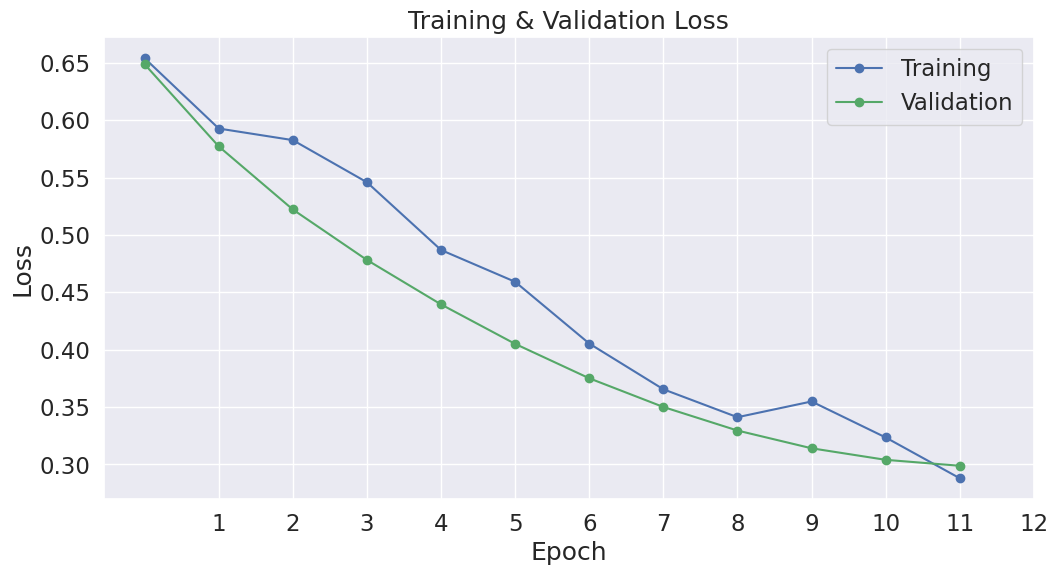

In [ ]:
# Dibujar un diagrama con train loss vs validation loss. Si todo sale bien,
# validation loss debería descender y estabilizarse, aunque igual puede hacer overfitting.
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Usar el estilo de dibujos de seaborn
sns.set(style='darkgrid')

# Agradar el area de dibujo y el tamaño de letra
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# dibujar las curvas de aprendizaje
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Ponerle titulo
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1, EPOCHS+1)))

plt.show()

### Guardar el modelo BERT ya modificado luego de fine-tuning

In [ ]:
# Guardar el modelo BERT con fine-tuning
import os
from pathlib import Path

# Esto es una convenciónx: si usa los nombres por defecto para los archivos del moelo,
# luego puede cargar todo usando from_pretrained()

output_dir = Path('./bert_fine_tuned/')

# Crear un directorio para guardar el modelo, si hace falta
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Guardando el modelo BERT con fine-tuning ee el directorio: {output_dir}")

# Guardar el modelo entrenado, la configuracion y el tokenizer usando `save_pretrained()`.
# Asi, todos pueden ser cargados usando `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Por diferencias entre entrenamiento distribuido/paralelo o no
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
# guardar una tabla de indice -> categoria
with open(output_dir / "label_texts.txt", "wt") as f:
  f.write(label_texts[0])
  for label_text in label_texts[1:]:
      f.write('\n')
      f.write(label_text)


Guardando el modelo BERT con fine-tuning ee el directorio: bert_fine_tuned


# PASO 2: Clasificar usando el modelo.

Luego de guardar un modelo ajustado con fine tuning, para cargar y clasificar usando el nuevo modelo que guardó, use el siguiente código:

In [ ]:
from transformers import BertForSequenceClassification
model_dir = "./bert_fine_tuned/"
print(f"Cargando modelo de clasificación BERT con finetuning desde el directorio: {model_dir}...")
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
with open(output_dir / "label_texts.txt", "rt") as f:
  label_texts = f.read().split('\n')
print(f"Modelo BERT en {model_dir} cargado.")

if is_gpu:
   # copiar al modelo desde CPU a GPU
    model.to(device)

test_sentences = [ "Riquelme siempre fue de Boca", "la militancia kirchnerista salta y salta"]

for sent in test_sentences:
    # `encode_plus` DEBE SIEMPRE usar los mismos parametros usados durante fine tuning
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Frase a codificar.
                        add_special_tokens = True, # Agregar '[CLS]' y '[SEP]'
                        max_length = MY_DATASET_MAX_TOKENS,  # Llenar con el token PAD a frases cortas, o truncar frases mas  largas que MAX_TOKENS
                        padding='max_length',
                        truncation=True,
                        return_token_type_ids=True,
                        return_attention_mask = True,   # Construir las attn. masks.
                        return_tensors = 'pt',     # retornar pytorch tensors.
                   )
    encoded_dict.to(device)
    # Este es el vector a clasficar, fijese que el largo del vector que codifica la frase es exactamente MY_DATASET_MAX_TOKENS
    print(encoded_dict["token_type_ids"].shape)

    output = model(**encoded_dict)
    # logits NO SON probabilidades (pero se pueden transformar a probabilidades).
    # logits pueden ser negativas, que significa que la probabilidada es < 0.5
    print(f"Frase: \"{sent}\"")
    print("Logits predichos para c/clase: ",output.logits.cpu().detach(), "Clase predicha:", label_texts[output.logits.argmax(dim=1).item()])


Cargando modelo de clasificación BERT con finetuning desde el directorio: ./bert_fine_tuned/...
Modelo BERT en ./bert_fine_tuned/ cargado.
torch.Size([1, 128])
Frase: "Riquelme siempre fue de Boca"
Logits predichos para c/clase:  tensor([[-0.2332,  0.4269]]) Clase predicha: deportes
torch.Size([1, 128])
Frase: "la militancia kirchnerista salta y salta"
Logits predichos para c/clase:  tensor([[0.0945, 0.0102]]) Clase predicha: politica
